In [1]:
from PIL import Image
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Input,Dropout,Dense,MaxPool2D,BatchNormalization,Flatten
from tensorflow.keras.models import Sequential

In [2]:
TRAIN_DIR = './NIKEAD/TRAIN'
TEST_DIR = './NIKEAD/TEST'
IMG_SIZE=120
LR = 1e-3

In [3]:
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == "NIKE":
        return [1,0]
    else:
        return [0,1]


def create_train_Data():
    train_Data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        
        img = Image.open(path)
        #img = img.convert('L')#Greyscale Conversion
        img = img.resize((IMG_SIZE,IMG_SIZE),Image.ANTIALIAS)
        
        train_Data.append([np.array(img),np.array(label)])
    shuffle(train_Data)
    return train_Data
    


100%|██████████| 100/100 [00:00<00:00, 128.27it/s]


[0 1]
(120, 120, 4)


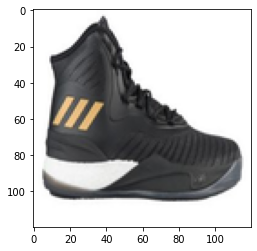

In [4]:
train_data = create_train_Data()
plt.imshow(train_data[43][0])
print(train_data[43][1])
print(train_data[43][0].shape)

In [5]:
def process_test_Data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        if 'DS_Store' not in path:
            image_num = img.split('_')[0] #images are formated NIKE_2,ADIDAS_34
            label = label_img(img)
            img = Image.open(path)
            #img = img.convert('L')
            img = img.resize((IMG_SIZE,IMG_SIZE),Image.ANTIALIAS)
            
            test_data.append([np.array(img),image_num,label])
    shuffle(test_data)
    return test_data

In [6]:
# CNN


model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding='same',input_shape=[IMG_SIZE,IMG_SIZE,4]))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

          
    
#Fully CONNECTED Layer with 1024 neurons
model.add(Dense(1024,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(2,activation="softmax"))
#A dropout with keep probab of 0.8 to finish the model
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      1184      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [15]:

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [16]:
train = train_data[-90:]
test = train_data[:-90]

X_train = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
y_test = [i[1] for i in test]


In [17]:
model.fit(X_train,np.array(y_train),validation_data=(X_test,np.array(y_test)),epochs=20,batch_size=10,verbose=1,shuffle=True,callbacks=callbacks)

Epoch 1/20
9/9 [==============================] - 4s 436ms/step - loss: 2.0053 - accuracy: 0.5778 - val_loss: 5.0901 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - 3s 386ms/step - loss: 0.9314 - accuracy: 0.7222 - val_loss: 6.1625 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - 3s 388ms/step - loss: 0.4186 - accuracy: 0.8333 - val_loss: 1.8785 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/20
9/9 [==============================] - 3s 380ms/step - loss: 0.2987 - accuracy: 0.8556 - val_loss: 1.1877 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/20
9/9 [==============================] - 3s 381ms/step - loss: 0.6647 - accuracy: 0.8667 - val_loss: 2.3977 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/20
9/9 [==============================] - 3s 379ms/step - loss: 0.4253 - accuracy: 0.8667 - val_loss: 1.8756 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 7/20
9/9 [==============================] - 3s 381ms/step - loss: 0.3374 - a

In [18]:
test_data = process_test_Data()



X_train = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
y_train = [i[1] for i in test_data]

100%|██████████| 40/40 [00:00<00:00, 123.64it/s]


In [19]:
import math
result = model.predict(X_train)
print(result[0])
for i in range(len(result)):
    if np.round((result[i][0]))== 1:
        print("Real = {}, Predcited = {} ".format(y_train[i],'NIKE'))
    else:
        print("Real = {}, Predcited = {} ".format(y_train[i],'Adidas'))

[0.16838899 0.831611  ]
Real = ADIDAS, Predcited = Adidas 
Real = ADIDAS, Predcited = Adidas 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = ADIDAS, Predcited = Adidas 
Real = NIKE, Predcited = NIKE 
Real = ADIDAS, Predcited = Adidas 
Real = ADIDAS, Predcited = NIKE 
Real = ADIDAS, Predcited = NIKE 
Real = ADIDAS, Predcited = Adidas 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = Adidas 
Real = ADIDAS, Predcited = NIKE 
Real = ADIDAS, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = NIKE, Predcited = NIKE 
Real = ADIDAS, Predcited = Adidas 
Real = ADIDAS, Predcited = Adidas 
Real = ADIDAS, Predcited = Adidas 
Real = ADIDAS, Predcited = Adidas 
Real = ADIDAS, Predcited = Adidas 
Real = ADIDAS, Predcited = Adidas 
Real = NIKE, Predcited = NIKE 
Real = ADIDAS, Predcite

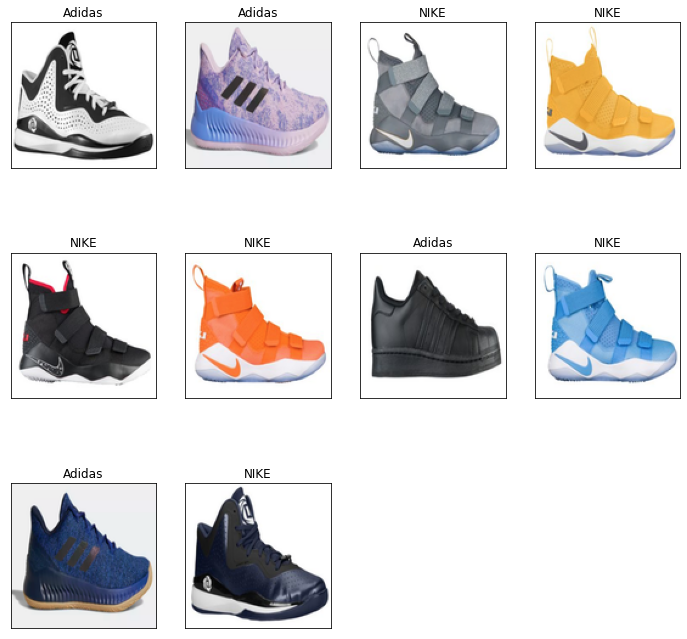

In [46]:
fig = plt.figure(figsize=(12,12))
for i in range(10):
    y = fig.add_subplot(3,4,i+1)
    if np.round(result[i][0])==1:
        label = 'NIKE'
    else:
        label = 'Adidas'
    y.imshow(X_train[i].reshape(120,120,4))
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    